In [1]:
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

In [2]:
import dice_ml

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.datasets import make_moons

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras

from sklearn.datasets import load_wine


In [3]:
def halfMoons(n_samples, noise):
    return make_moons(n_samples=n_samples, shuffle=True, noise=noise, random_state=RANDOM_STATE)

In [4]:
def displayScatter(X, color=None, title=None, i=None):
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=color)
    
    if i != None:
        plt.scatter(X[i, 0], X[i, 1], marker="+", s=200, c='indigo')        

    plt.title(title)
    plt.show()

## Données

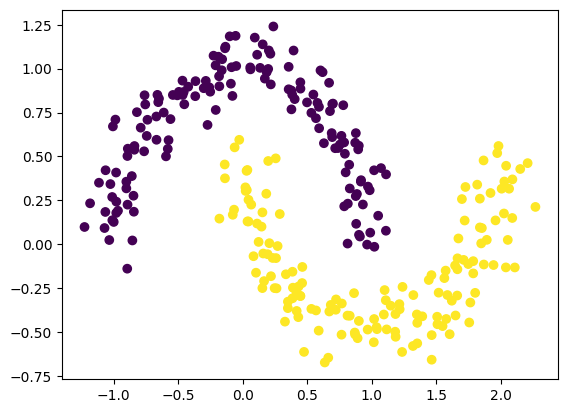

In [5]:
X_np, y_np = halfMoons(300, 0.1)
displayScatter(X_np, y_np)

In [6]:
data_df = pd.DataFrame(np.hstack((X_np, y_np.reshape(-1, 1))), columns=['x1', 'x2', 'y'])
data_df

,x1,x2,y
0,0.682988,-0.345203,1.0
1,2.040990,-0.131615,1.0
2,-0.139752,0.454391,1.0
3,0.885748,0.286342,0.0
4,1.182459,-0.497711,1.0
...,...,...,...
295,0.385833,-0.156333,1.0
296,0.202356,1.103499,0.0
297,-0.661774,0.850728,0.0
298,1.666161,-0.079847,1.0


## Classifieurs

In [7]:
data = dice_ml.Data(dataframe=data_df, continuous_features=["x1", "x2"], outcome_name="y")

clf = keras.Sequential([
    keras.layers.Input(shape=(X_np.shape[1],)),
    keras.layers.Dense(20, activation='tanh'),
    keras.layers.Dense(17, activation='relu'),
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])

clf.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
clf.fit(X_np, y_np, epochs=200, batch_size=100)
trained_classifier = clf
backend = "TF1"

Epoch 1/200


3/3 [==============================] - 1s 0s/step - loss: 0.6275 - accuracy: 0.7867
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6085 - accuracy: 0.8567
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 0.5893 - accuracy: 0.8467
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 0.5717 - accuracy: 0.8400
Epoch 5/200
3/3 [==============================] - 0s 0s/step - loss: 0.5560 - accuracy: 0.8367
Epoch 6/200
3/3 [==============================] - 0s 0s/step - loss: 0.5401 - accuracy: 0.8267
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.5262 - accuracy: 0.8200
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 0.5134 - accuracy: 0.8200
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 0.5011 - accuracy: 0.8200
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4900 - accuracy: 0.8200
Epoch 11/200
3/3 [==========================

In [8]:
model = dice_ml.Model(model=trained_classifier, backend=backend)


## Génération d'ensembles contre-factuels

In [9]:
explainer = dice_ml.Dice(data, model)

query_instance = data_df.drop(columns="y")[0:1]
counterfactuals = explainer.generate_counterfactuals(
    query_instances=query_instance,
    total_CFs=5,
    desired_class="opposite",
    proximity_weight=0.5,
    diversity_weight=1.0,
    features_to_vary="all",
    permitted_range=None,
    posthoc_sparsity_param=0.1)

counterfactuals.visualize_as_dataframe()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:29<00:00, 29.43s/it]

Query instance (original outcome : 1)


,x1,x2,y
0,0.682988,-0.345203,1



Diverse Counterfactual set (new outcome: 0.0)


,x1,x2,y
0,0.682988,0.231098,0
1,0.682988,1.025476,0
2,0.682988,0.014100,0
3,0.682988,0.148036,0
4,0.571058,0.671889,0


In [10]:
counterfactuals.cf_examples_list[0].final_cfs_df

,x1,x2,y
0,0.682988,0.231098,0
1,0.682988,1.025476,0
2,0.682988,0.014100,0
3,0.682988,0.148036,0
4,0.571048,0.671889,0


## Visualisation et expérimentations

In [11]:
def visualize_contrefactuel(model, X, y, index, contrefactuels, ax, classes=[0, 1], title="", label=True):
    
        data_to_explain = X[index]
    
        colors = ["navajowhite", "powderblue"]
        classes = classes

        ax.set_title(title)

        y = y.reshape(-1)
        for j, cl in enumerate(classes):
            X_cl = X[y == cl]
            ax.scatter(
                X_cl[:, 0],
                X_cl[:, 1],
                c=colors[j],
                label=f"Classe : {cl}" if label else "",
            )

        mmax = X.max(0)
        mmin = X.min(0)

        step = 1000
        x1grid, x2grid = np.meshgrid(
            np.linspace(mmin[0], mmax[0], step), np.linspace(mmin[1], mmax[1], step)
        )

        grid = np.hstack(
            (x1grid.reshape(x1grid.size, 1), x2grid.reshape(x2grid.size, 1))
        )

        res = np.round(model.predict(grid))
        res = res.reshape(x1grid.shape)

        ax.contourf(
            x1grid,
            x2grid,
            res,
            colors=colors,
            levels=[-1000, 0, 1000],
            alpha=0.4,
        )

        ax.scatter(data_to_explain[0], data_to_explain[1], marker="+", s=200, c='indigo', label=f"exemple" if label else "")        

        for contrefactuel in contrefactuels:
            ax.scatter(contrefactuel[0], contrefactuel[1], marker="x", s=200, c='firebrick', label=f"contre factuel" if label else "")

100%|██████████| 1/1 [00:29<00:00, 29.09s/it]

Query instance (original outcome : 1)


,x1,x2,y
0,0.682988,-0.345203,1



Diverse Counterfactual set (new outcome: 0.0)


,x1,x2,y
0,0.682988,1.103550,0
1,0.682988,0.145371,0
2,-0.874518,-0.290976,0
3,0.682988,0.275872,0
4,-0.046624,0.699204,0


31250/31250 [==============================] - 20s 623us/step


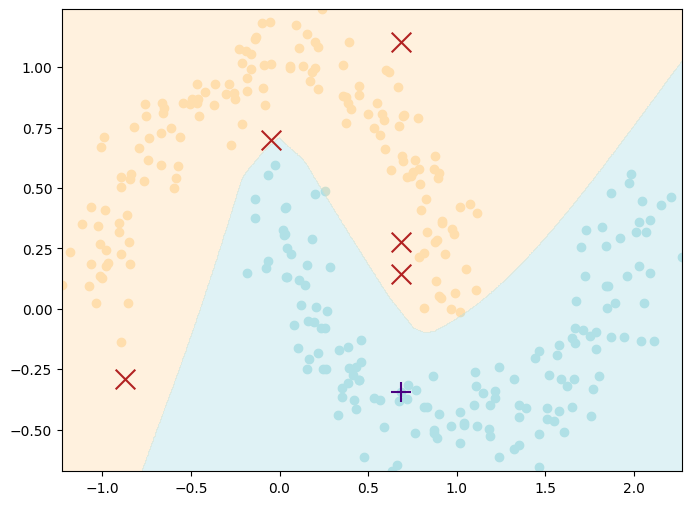

In [12]:
query_instance = pd.DataFrame(np.array([X_np[0]]), columns=["x1", "x2"])

counterfactuals = explainer.generate_counterfactuals(
    query_instances=query_instance,
    total_CFs=5,
    desired_class="opposite",
    proximity_weight=0.5,
    diversity_weight=1.0,
    features_to_vary="all",
    permitted_range=None,
    posthoc_sparsity_param=0.1)

counterfactuals.visualize_as_dataframe()

counterfactuals = counterfactuals.cf_examples_list[0].final_cfs_df
counterfactuals = counterfactuals.drop(columns="y").values

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
visualize_contrefactuel(trained_classifier, X_np, y_np, 0, counterfactuals, ax)

### Expérimentations

### - Variation de l'exemple requête : 

100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

  130/31250 [..............................] - ETA: 25s 

31250/31250 [==============================] - 22s 696us/step


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

  174/31250 [..............................] - ETA: 19s 

31250/31250 [==============================] - 21s 680us/step


100%|██████████| 1/1 [00:28<00:00, 28.83s/it]

   60/31250 [..............................] - ETA: 30s  

31250/31250 [==============================] - 450s 14ms/step


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

  106/31250 [..............................] - ETA: 33s 

31250/31250 [==============================] - 24s 776us/step


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  119/31250 [..............................] - ETA: 30s 

31250/31250 [==============================] - 24s 756us/step


100%|██████████| 1/1 [00:30<00:00, 30.11s/it]

  120/31250 [..............................] - ETA: 29s 

31250/31250 [==============================] - 24s 771us/step


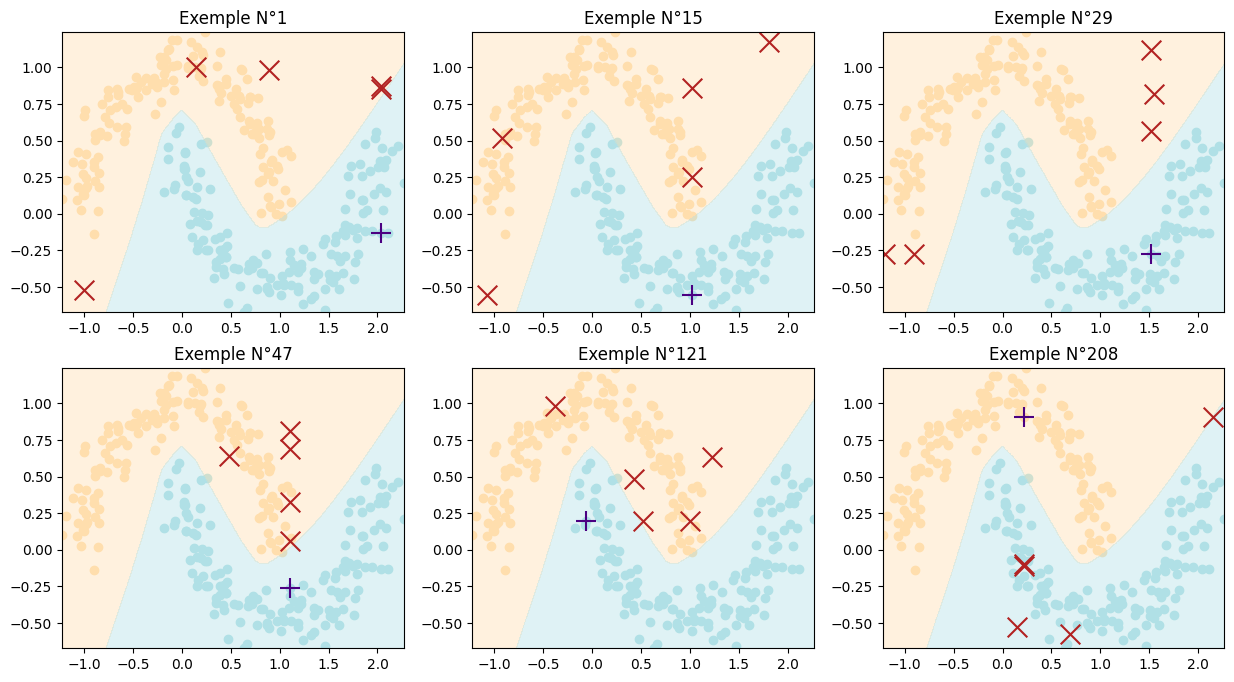

In [13]:
requetes = [1, 15, 29, 47, 121, 208]

nrows = len(requetes) // 3
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))

i = 0
j = 0

for indice in requetes:

    query_instance = pd.DataFrame(np.array([X_np[indice]]), columns=["x1", "x2"])
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=query_instance,
        total_CFs=5,
        desired_class="opposite",
        proximity_weight=1.0,
        diversity_weight=0.2,
        features_to_vary="all",
        permitted_range=None,
        posthoc_sparsity_param=0.1)
    counterfactuals = counterfactuals.cf_examples_list[0].final_cfs_df
    counterfactuals = counterfactuals.drop(columns="y").values

    visualize_contrefactuel(trained_classifier, X_np, y_np, indice, counterfactuals, axs[i][j], title=f"Exemple N°{indice}")
    
    j += 1
    if j == ncols:
        i += 1
        j = 0

On observe que pour chaque exemple, les contrefactuels diffèrent, présentant ainsi une distribution variée. Toutefois, avec les paramètres actuels, ces distributions semblent plutôt éparpier. Il est important de noter que ces résultats peuvent varier en fonction des paramètres de recherche ainsi que du modèle utilisé.

De plus, il est à souligner que les contrefactuels générés ne sont pas tous valides en raison des performances médiocres du modèle.(exemple N1 avec le contrefactuel le plus proche) 

### - Variation des params : 

**On commence à varier le proximity_weights :**

100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

  164/31250 [..............................] - ETA: 21s 

31250/31250 [==============================] - 22s 695us/step


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

  144/31250 [..............................] - ETA: 24s 

31250/31250 [==============================] - 21s 663us/step


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

   65/31250 [..............................] - ETA: 28s  

31250/31250 [==============================] - 21s 678us/step


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

   19/31250 [..............................] - ETA: 1:37 

31250/31250 [==============================] - 24s 764us/step


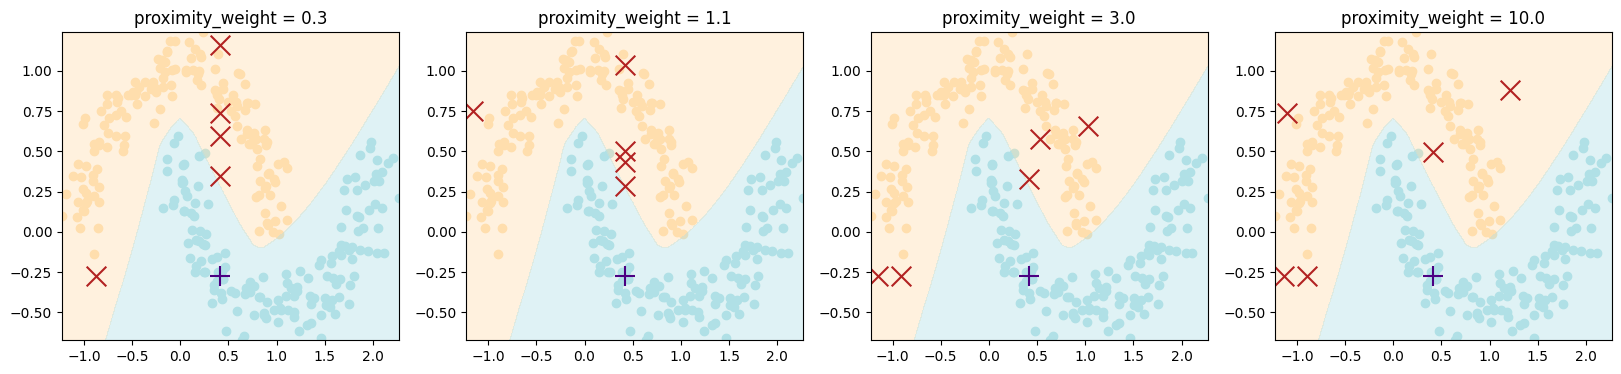

In [14]:
proximity_weights = [0.3, 1.1, 3., 10.]

indice = 128
fig, axs = plt.subplots(nrows=1, ncols=len(proximity_weights), figsize=(20, 4))

i = 0
for p in proximity_weights:
    query_instance = pd.DataFrame(np.array([X_np[indice]]), columns=["x1", "x2"])
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=query_instance,
        total_CFs=5,
        desired_class="opposite",
        proximity_weight=p,
        diversity_weight=0.0,
        features_to_vary="all",
        permitted_range=None,
        posthoc_sparsity_param=0.0)
    counterfactuals = counterfactuals.cf_examples_list[0].final_cfs_df
    counterfactuals = counterfactuals.drop(columns="y").values

    visualize_contrefactuel(trained_classifier, X_np, y_np, indice, counterfactuals, axs[i], title=f"proximity_weight = {p}")
    i += 1

Dans cette expérience, nous cherchons à examiner l'impact du poids de proximité sur les contrefactuels générés. À cette fin, nous avons maintenu les poids de diversité et de sparsité à 0 et modifié celui de proximité.

L'idée sous-jacente est de démontrer que plus le poids de proximité est élevé, plus la distance entre l'exemple et ses contrefactuels est réduite. En effet, on observe que les contrefactuels tendent à se rapprocher davantage de l'exemple choisi à mesure que le poids de proximité augmente. Cependant, les résultats ne sont pas suffisamment convaincants, car la différence entre les valeurs faibles et élevées du poids n'est pas particulièrement significative.

Cette observation pourrait potentiellement s'expliquer par les valeurs nulles des poids de diversité et de sparsité, suggérant que ces aspects pourraient également jouer un rôle crucial dans la génération des contrefactuels.

**On varie le diversity_weight :**

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

   59/31250 [..............................] - ETA: 30s  

31250/31250 [==============================] - 22s 713us/step


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

   59/31250 [..............................] - ETA: 30s  

31250/31250 [==============================] - 25s 810us/step


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

  108/31250 [..............................] - ETA: 33s 

31250/31250 [==============================] - 24s 771us/step


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

  118/31250 [..............................] - ETA: 29s 

31250/31250 [==============================] - 24s 769us/step


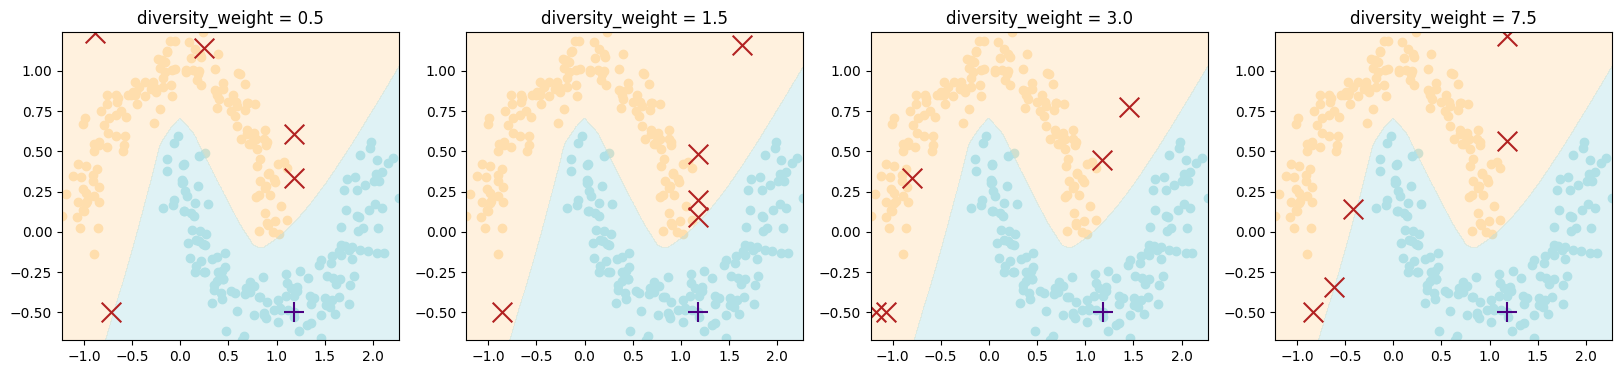

In [15]:
diversity_weight = [0.5, 1.5, 3., 7.5]

indice = 4
fig, axs = plt.subplots(nrows=1, ncols=len(diversity_weight), figsize=(20, 4))

i = 0
for p in diversity_weight:
    query_instance = pd.DataFrame(np.array([X_np[indice]]), columns=["x1", "x2"])
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=query_instance,
        total_CFs=5,
        desired_class="opposite",
        proximity_weight=0.0,
        diversity_weight=p,
        features_to_vary="all",
        permitted_range=None,
        posthoc_sparsity_param=0.0)
    counterfactuals = counterfactuals.cf_examples_list[0].final_cfs_df
    counterfactuals = counterfactuals.drop(columns="y").values

    visualize_contrefactuel(trained_classifier, X_np, y_np, indice, counterfactuals, axs[i], title=f"diversity_weight = {p}")
    i += 1

Dans cette étude, notre objectif est d'analyser comment le poids de la diversité influe sur les contrefactuels générés. À cette fin, les poids de proximité et de parcimonie ont été maintenus à zéro, tandis que celui de la diversité a été modifié.

L'idée sous-jacente est de démontrer que l'augmentation du poids de la diversité entraîne une augmentation de la distance entre les contrefactuels. En d'autres termes, à mesure que le poids de la diversité augmente, on observe une tendance des contrefactuels à se distancer les uns des autres.

Cependant, les résultats ne sont pas suffisamment convaincants. Cela pourrait être attribué aux valeurs nulles des autres poids, ainsi qu'à la faible dimension des données. Ces facteurs pourraient avoir une influence sur la robustesse des conclusions tirées de l'expérience.

### - Extension de Growing Spheres :

In [16]:
class Exception_GS(Exception):
    def __init__(self, message="Try to modify a feature in a wrong range"):
        self.message = message
        super().__init__(self.message)

def uniform_in_sphere(x,n_samples,a_0,a_1):
    d = x.shape[0]
    # sample from gaussian distribution
    samples = np.random.normal(0,1,(n_samples,d))

    # normalization
    samples_norm = samples / np.linalg.norm(samples,axis=1).reshape(-1,1)
    # sample from uniform distribution
    u = np.random.uniform(a_0**d,a_1**d,1) ** (1/d)

    return x + samples_norm * u


def algorithme_gs_generation(model,sample,eta,n_samples):

    generated_samples_sph = uniform_in_sphere(sample,n_samples,0,eta)

    prediction_samples_sph = model.predict(generated_samples_sph)

    while np.where(prediction_samples_sph != model.predict(sample.reshape(1,-1)),1,0).sum() != 0:

        eta = eta / 2

        generated_samples_sph = uniform_in_sphere(sample,n_samples,0,eta)

        prediction_samples_sph = model.predict(generated_samples_sph)

    a_0 = eta
    a_1 = 2*eta

    while np.where(prediction_samples_sph != model.predict(sample.reshape(1,-1)),1,0).sum() == 0:

        generated_samples_sph = uniform_in_sphere(sample,n_samples,a_0,a_1)

        prediction_samples_sph = model.predict(generated_samples_sph)

        a_0 = a_1
        a_1 = a_1 + eta

    prediction_samples_sph = model.predict(generated_samples_sph)
    samples_diff_class = generated_samples_sph[np.where(prediction_samples_sph != model.predict(sample.reshape(1,-1)))]

    enemy_ind = np.argmin(np.linalg.norm(np.array(samples_diff_class) - np.array(sample),axis=1))

    return samples_diff_class[enemy_ind]

def algorithme_gs_feature_selection(model,sample,enemy,non_modifiable_att='no',variation_range='no'):

    """
      **non_modifiable_att** : list of non modifiable attributes
      **variation_range** : a dictionnary {key:feature_index , value:range}
    """

    enemy_prime = enemy.copy()
    relevant_dimensions = []

    while model.predict(sample.reshape(1,-1)) != model.predict(enemy_prime.reshape(1,-1)):

        enemy_star = enemy_prime.copy()

        indices_diffe_dim = np.where(enemy_prime != sample)[0]

        indi = indices_diffe_dim[np.argmin(enemy_prime[indices_diffe_dim] - sample[indices_diffe_dim])]

        if indi not in non_modifiable_att:

          if variation_range == 'no':
            relevant_dimensions.append(indi)
            enemy_prime[indi] = sample[indi]
          else:
            if (sample[indi]  >= variation_range[indi][0]) and (sample[indi]  <= variation_range[indi][1]):

              relevant_dimensions.append(indi)
              enemy_prime[indi] = sample[indi]

            else:
              raise Exception_GS(f"Try to modify a feature in a wrong range , {indi}")

        else:
          raise Exception_GS(f"Try to modify a non-modifiable feature , {indi}")


    return enemy_star , relevant_dimensions



def growing_sphere(rd_model,sample,eta=5,n_samples=10,non_modifiable_att='no',variation_range='no'):

  not_finish = True

  enemy = algorithme_gs_generation(rd_model,sample,eta,n_samples)

  while not_finish:

    try :
      return algorithme_gs_feature_selection(rd_model,sample,enemy,non_modifiable_att,variation_range)
    except Exception as e:
      enemy = algorithme_gs_generation(rd_model,sample,eta,n_samples)


In [17]:
wine_data = load_wine()

X = wine_data.data  
y = wine_data.target  

In [18]:
rd_model = RandomForestClassifier(max_depth=5)
rd_model.fit(X,y)

RandomForestClassifier(max_depth=5)